# **Imports**

In [1]:
#uncomment this if you are running the notebook for the first time
!pip install pretty-confusion-matrix
import torch
import torchvision
import torch.nn as nn  
import torch.optim as optim  
import torch.nn.functional as F  
from torch.utils.data import (
    DataLoader,
    Dataset,
) 
import torchvision.datasets as datasets
import torchvision.transforms as transforms 
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
from PIL import Image
from sklearn.metrics import roc_curve
import pandas as pd
from pretty_confusion_matrix import pp_matrix_from_data
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.9/201.9 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 110.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 KB 44.7 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post1

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!tar -xvzf "/content/drive/MyDrive/lenses.tgz";

Streaming output truncated to the last 5000 lines.
lenses/sub/image_100015241301657914033614173596761104525.jpg
lenses/sub/image_100019258133324150161414627571840489791.jpg
lenses/sub/image_100037595382723842062692422633464214182.jpg
lenses/sub/image_100051752665265895059841674396483507971.jpg
lenses/sub/image_100061050381335122405719538882377792147.jpg
lenses/sub/image_100197909896237775032543464299896775969.jpg
lenses/sub/image_100320807541648655929202108326967225168.jpg
lenses/sub/image_100328038748633664502728939498999939178.jpg
lenses/sub/image_100414429896197675867404359083606673007.jpg
lenses/sub/image_100417428819094526025015583687314128031.jpg
lenses/sub/image_100420135487186127075592600341613352821.jpg
lenses/sub/image_100421750518816277824738277767206924323.jpg
lenses/sub/image_100462348085513038268081370949998047036.jpg
lenses/sub/image_100466995792859747756314577205445431577.jpg
lenses/sub/image_1004743667648648993666680301317488948.jpg
lenses/sub/image_1004939629743954907

# **Visualizations**

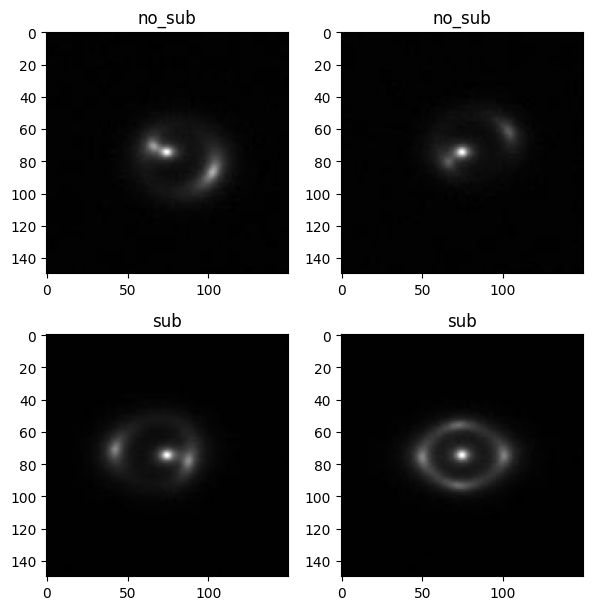

In [5]:
subfolders = ["no_sub", "sub"]
n_images = 2
fig = plt.figure(figsize=(9,9))
for i, subfolder in enumerate(subfolders):

    image_files = os.listdir(os.path.join("/content/lenses", subfolder))

    for j, image_file in enumerate(image_files[:n_images]):

        img = Image.open(os.path.join("/content/lenses", subfolder, image_file))
        ax = fig.add_subplot(3, 3, i*3 + j + 1)
        ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        ax.set_title(subfolder)


plt.tight_layout()
plt.show()

# **Augmentation**

In [6]:
transform = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(100)], p=0.40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation([-90,90]),
    transforms.ToTensor()
])

In [7]:
root_dir = "/content/lenses"
subfolders = ["no_sub", "sub"]

for subdir in subfolders:
    subdir_path = os.path.join(root_dir, subdir)
    images = os.listdir(subdir_path)
    images.sort()
    for i, image in enumerate(images):
        if i < 500:
            continue
        image_path = os.path.join(subdir_path, image)
        img_array = Image.open(image_path)
        img_array = np.float32(img_array)
        pil_image = Image.fromarray(img_array)
        for j in range(1):
            transformed_image = transform(pil_image)
  
            transformed_image = np.array(transformed_image)
            # Save as .jpg file with a suffix
            
            transformed_image = (transformed_image - np.min(transformed_image)) / (np.max(transformed_image) - np.min(transformed_image)) * 255
  
            transformed_image = transformed_image.squeeze(0)
            transformed_image = Image.fromarray(transformed_image.astype('uint8'))
            
            new_image_path = image_path[:-4] + f"_{j}.jpg"
            transformed_image.save(new_image_path)

In [8]:
dir_list = os.listdir("/content/lenses/sub")
dir_length = len(dir_list)
print(dir_length)

9500


# **Loading The Data**

In [9]:
class LensesDataset(Dataset):
  def __init__(self, root_dir, subfolders, transform=None, mode="train"):
    self.root_dir = root_dir
    self.subfolders = subfolders
    self.transform = transform
    self.mode = mode

    self.images = []
    self.labels = []
    for subdir in subfolders:
      subdir_path = os.path.join(root_dir, subdir)
      images = os.listdir(subdir_path)
      images.sort()
      if mode == "train":
        for i, image in enumerate(images):
          if i < 500:
            continue
          image_path = os.path.join(subdir_path, image)
          self.images.append(image_path)
          if subdir == "no_sub":
            self.labels.append(0)
          elif subdir == "sub":
            self.labels.append(1)

      elif mode == "val":
        for i, image in enumerate(images):
          if i >= 500:
            break
          image_path = os.path.join(subdir_path, image)
          self.images.append(image_path)
          # Assign label based on subfolder name
          if subdir == "no_sub":
            self.labels.append(0)
          elif subdir == "sub":
            self.labels.append(1)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_path = self.images[idx]

    img_array = Image.open(image_path)
    img_array = np.float32(img_array)
    img_array = np.squeeze(img_array)
    pil_image = Image.fromarray(img_array)

    if self.transform:
      pil_image = self.transform(pil_image)

    label = torch.tensor(self.labels[idx])
    return pil_image, label

transform_data = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.Grayscale(num_output_channels=3),
  transforms.Lambda(lambda x: np.array(x).astype('float32') / 255),
  transforms.ToTensor()
])

In [10]:
root_dir = "/content/lenses"
subfolders = ["no_sub", "sub"]

train_dataset = LensesDataset(root_dir=root_dir,
                              subfolders=subfolders,
                              transform=transform_data,
                              mode="train")

val_dataset = LensesDataset(root_dir=root_dir,
                            subfolders=subfolders,
                            transform=transform_data,
                            mode="val")

train_dataloader = DataLoader(train_dataset,
                               batch_size=50,
                               shuffle=True)

val_dataloader = DataLoader(val_dataset,
                             batch_size=50,
                             shuffle=False)

In [11]:
print(f"Train dataloader size: {len(train_dataloader)}")
print(f"Val dataloader size: {len(val_dataloader)}")

Train dataloader size: 360
Val dataloader size: 20


In [12]:
next(iter(train_dataloader))[0].shape

torch.Size([50, 3, 224, 224])

# **Model Definition**

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.swin_t(weights=True)
model.head = nn.Sequential(
    nn.Linear(768, 2),
)
model.to(device);

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth


  0%|          | 0.00/108M [00:00<?, ?B/s]

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# **Evaluation Function**

In [20]:
def evaluate(model, dataloader, criterion):
    losses = []
    all_targets = []
    all_scores = []
    probabilities = []
    model.eval()

    with torch.no_grad():
        for data, targets in dataloader:

            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = model(data)
            prob = F.softmax(scores, dim=1)
            probabilities.extend(prob.tolist())

            loss = criterion(scores, targets)

            losses.append(loss.item())
            all_targets.extend(targets.cpu().numpy())
            all_scores.extend(scores.detach().cpu().numpy())

        avg_loss = sum(losses) / len(losses)


        labels = np.array(all_targets)
        probabilities = np.array(probabilities)
        avg_auc = roc_auc_score(labels, probabilities[:,1])

        _, preds = torch.max(torch.tensor(all_scores), 1)
        correct = (preds == torch.tensor(all_targets)).float()
        accuracy = torch.sum(correct) / len(all_targets)
        
        y_pred = preds.numpy()
        y_true = np.array(all_targets)

         

    return avg_loss, avg_auc, accuracy, y_pred, y_true

# **Model Training**

In [21]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [22]:
AUC_list = []
best_auc_val_score = 0
for epoch in range(15):
    losses = []
    all_targets = []
    all_scores = []
    probabilities = []

    model.train()

    for data, targets in tqdm(train_dataloader):
      
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model.forward(data)
        prob = F.softmax(scores, dim=1)
        probabilities.extend(prob.tolist())
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        all_targets.extend(targets.cpu().numpy())
        all_scores.extend(scores.detach().cpu().numpy())

    avg_loss_train = sum(losses) / len(losses)


    labels = np.array(all_targets)
    probabilities = np.array(probabilities)

    

    _, preds = torch.max(torch.tensor(all_scores), 1)
    correct = (preds == torch.tensor(all_targets)).float()
    accuracy = torch.sum(correct) / len(all_targets)

    avg_auc = roc_auc_score(labels, probabilities[:,1])
    AUC_list.append(avg_auc)

    avg_loss_test, avg_auc_test, accuracy_test, _ ,_ = evaluate(model,val_dataloader,criterion)
    scheduler.step(avg_loss_test)
    if avg_auc_test > best_auc_val_score:
            # Update the best validation score
            best_auc_val_score = avg_auc_test
            
            # Save the model state dictionary and other information
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_score': avg_auc_test
            }, 'best_model.pth')

    print(f"\nEpoch No. {epoch}\n======\n")
    print(f"Training Loss is {avg_loss_train:.5f}, Validation Loss is {avg_loss_test:.5f}")
    print(f"Training AUC is {avg_auc:.5f}, Validation AUC is {avg_auc_test:.5f}")
    print(f"Training Accuracy is {accuracy:.5f}, Validation Accuracy is{accuracy_test:.5f}")
    print("===============\n")

100%|██████████| 360/360 [04:15<00:00,  1.41it/s]



Epoch No. 0

Training Loss is 0.69782, Validation Loss is 0.67923
Training AUC is 0.51577, Validation AUC is 0.69399
Training Accuracy is 0.50861, Validation Accuracy is0.58800



100%|██████████| 360/360 [04:16<00:00,  1.40it/s]



Epoch No. 1

Training Loss is 0.63920, Validation Loss is 0.36835
Training AUC is 0.65757, Validation AUC is 0.93114
Training Accuracy is 0.60122, Validation Accuracy is0.80200



100%|██████████| 360/360 [04:17<00:00,  1.40it/s]



Epoch No. 2

Training Loss is 0.38323, Validation Loss is 0.10244
Training AUC is 0.90296, Validation AUC is 0.99490
Training Accuracy is 0.80589, Validation Accuracy is0.95900



100%|██████████| 360/360 [04:17<00:00,  1.40it/s]



Epoch No. 3

Training Loss is 0.22443, Validation Loss is 0.07324
Training AUC is 0.96888, Validation AUC is 0.99876
Training Accuracy is 0.89800, Validation Accuracy is0.96600



100%|██████████| 360/360 [04:18<00:00,  1.39it/s]



Epoch No. 4

Training Loss is 0.17042, Validation Loss is 0.19265
Training AUC is 0.98234, Validation AUC is 0.99612
Training Accuracy is 0.92739, Validation Accuracy is0.92400



100%|██████████| 360/360 [04:20<00:00,  1.38it/s]



Epoch No. 5

Training Loss is 0.11827, Validation Loss is 0.08771
Training AUC is 0.99147, Validation AUC is 0.99975
Training Accuracy is 0.95317, Validation Accuracy is0.96600



100%|██████████| 360/360 [04:20<00:00,  1.38it/s]



Epoch No. 6

Training Loss is 0.10384, Validation Loss is 0.03485
Training AUC is 0.99337, Validation AUC is 0.99948
Training Accuracy is 0.95806, Validation Accuracy is0.98400



100%|██████████| 360/360 [04:20<00:00,  1.38it/s]



Epoch No. 7

Training Loss is 0.08345, Validation Loss is 0.04044
Training AUC is 0.99570, Validation AUC is 0.99988
Training Accuracy is 0.96806, Validation Accuracy is0.98000



100%|██████████| 360/360 [04:20<00:00,  1.38it/s]



Epoch No. 8

Training Loss is 0.07502, Validation Loss is 0.01986
Training AUC is 0.99649, Validation AUC is 0.99981
Training Accuracy is 0.97067, Validation Accuracy is0.99300



100%|██████████| 360/360 [04:20<00:00,  1.38it/s]



Epoch No. 9

Training Loss is 0.06135, Validation Loss is 0.01724
Training AUC is 0.99765, Validation AUC is 0.99994
Training Accuracy is 0.97656, Validation Accuracy is0.99300



100%|██████████| 360/360 [04:20<00:00,  1.38it/s]



Epoch No. 10

Training Loss is 0.06024, Validation Loss is 0.04479
Training AUC is 0.99769, Validation AUC is 0.99960
Training Accuracy is 0.97728, Validation Accuracy is0.98600



100%|██████████| 360/360 [04:20<00:00,  1.38it/s]



Epoch No. 11

Training Loss is 0.05576, Validation Loss is 0.02262
Training AUC is 0.99808, Validation AUC is 0.99978
Training Accuracy is 0.97800, Validation Accuracy is0.99200



100%|██████████| 360/360 [04:20<00:00,  1.38it/s]



Epoch No. 12

Training Loss is 0.04675, Validation Loss is 0.03390
Training AUC is 0.99856, Validation AUC is 0.99951
Training Accuracy is 0.98278, Validation Accuracy is0.98600



100%|██████████| 360/360 [04:20<00:00,  1.38it/s]



Epoch No. 13

Training Loss is 0.05035, Validation Loss is 0.02291
Training AUC is 0.99834, Validation AUC is 0.99975
Training Accuracy is 0.98156, Validation Accuracy is0.99400



100%|██████████| 360/360 [04:20<00:00,  1.38it/s]



Epoch No. 14

Training Loss is 0.02134, Validation Loss is 0.02179
Training AUC is 0.99965, Validation AUC is 0.99983
Training Accuracy is 0.99306, Validation Accuracy is0.99300



# **Loading and Testing**

In [25]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [26]:
avg_loss_test, avg_auc_test, accuracy_test,y_pred,y_true = evaluate(model,
                                                      val_dataloader,
                                                      criterion)

print(f"\nValidation AUC score is {avg_auc_test:.10f}")
    
print(f"Validation Accuracy is {accuracy_test:.10f}")

print(f"Validation Loss is {avg_loss_test:.10f}")


Validation AUC score is 0.9999360000
Validation Accuracy is 0.9929999709
Validation Loss is 0.0172433024


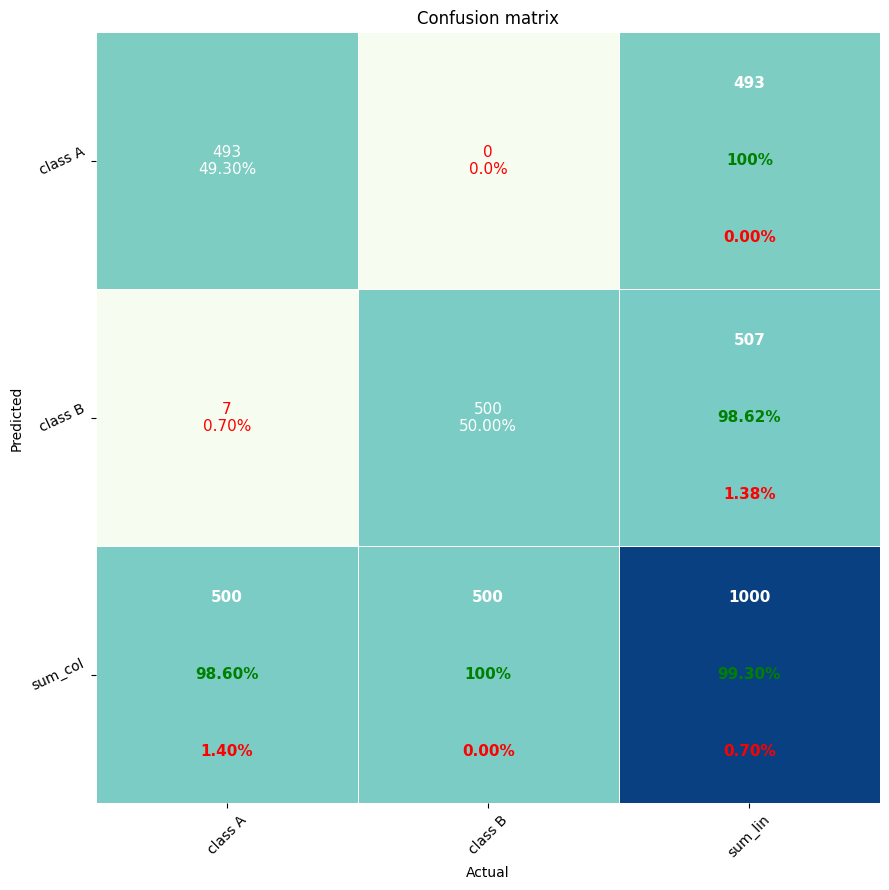

In [27]:
pp_matrix_from_data(y_true, y_pred,cmap = 'GnBu')

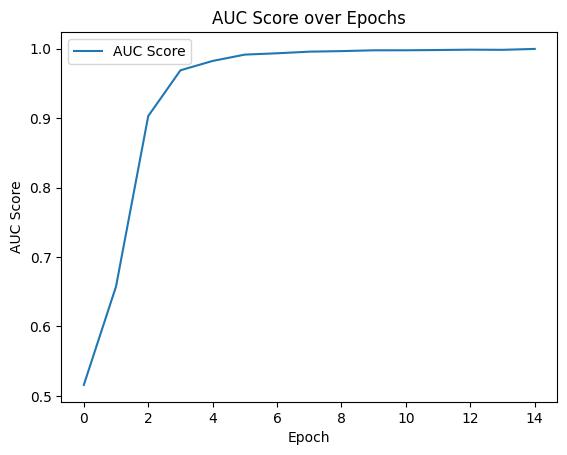

In [28]:
plt.plot(range(0, 15), AUC_list)
plt.xlabel("Epoch")
plt.ylabel("AUC Score")
plt.title("AUC Score over Epochs")
plt.legend(["AUC Score"])

plt.show() 

# **ROC Curve**

(1000,) (2000,)


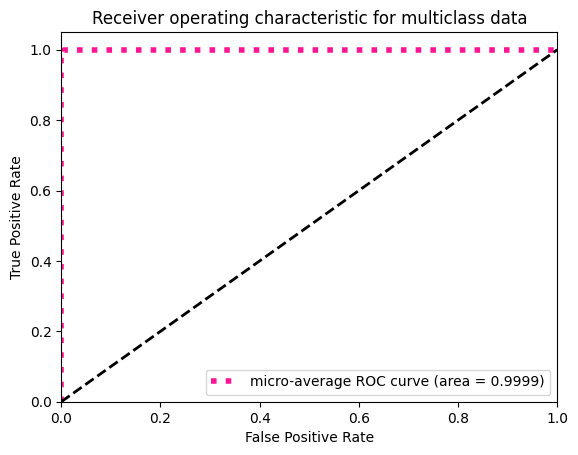

In [56]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

model.to(device)
y_score = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in val_dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        logits = model(X_batch)
        probs = F.softmax(logits, dim=1)
        y_score.append(probs)
        y_true.append(y_batch)

y_score = torch.cat(y_score).cpu().numpy()
y_true = torch.cat(y_true).cpu().numpy()

y_test = label_binarize(y_true, classes=[0, 1])
n_classes = y_test.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
print(y_test.ravel().shape, y_score.ravel().shape)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.4f})'
         ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multiclass data')
plt.legend(loc="lower right")
plt.show()

In [43]:
torch.save(model.state_dict(), "/content/first.pth")